<h2><b> Importing Dataset and Libraries

In [ ]:
# !git clone https://github.com/microsoft/MS-SNSD.git

Cloning into 'MS-SNSD'...
remote: Enumerating objects: 29924, done.
remote: Total 29924 (delta 0), reused 0 (delta 0), pack-reused 29924 (from 1)
Receiving objects: 100% (29924/29924), 3.93 GiB | 32.89 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Updating files: 100% (24399/24399), done.


In [ ]:
import librosa
import librosa.display
import soundfile as sf
import IPython.display as ipd

import numpy as np
import os
import time
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, BatchNormalization, Activation,
    Flatten, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


<h2><b> Converting to Spectogram

In [ ]:
base_dir='MS-SNSD/'
noisy_folder = os.path.join(base_dir, 'NoisySpeech_training')
clean_folder = os.path.join(base_dir, 'CleanSpeech_training')

Inspecting file: noisy396_SNRdb_10.0_clnsp396.wav


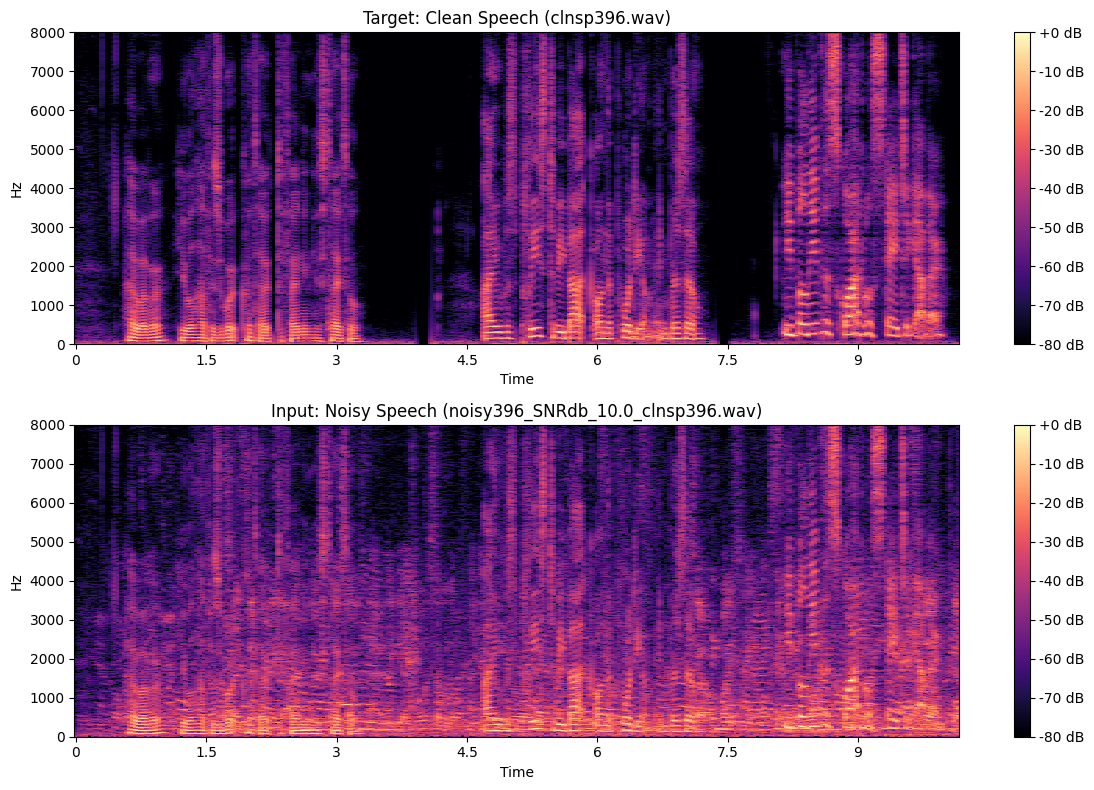

In [ ]:
files = os.listdir(noisy_folder)
wav_files = [f for f in files if f.endswith('.wav')]

if not wav_files:
    print("Error: No .wav files found in NoisySpeech_training!")
else:
    filename = wav_files[0]
    print(f"Inspecting file: {filename}")

    noisy_path = os.path.join(noisy_folder, filename)

    file_id = filename.split('_')[-1]
    clean_path = os.path.join(clean_folder, file_id)

    if not os.path.exists(clean_path):
        print(f"Note: Exact match {file_id} not found. Using first available clean file.")
        clean_path = os.path.join(clean_folder, [f for f in os.listdir(clean_folder) if f.endswith('.wav')][0])

    noisy_audio, sr = librosa.load(noisy_path, sr=16000)
    clean_audio, _ = librosa.load(clean_path, sr=16000)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    D_clean = librosa.amplitude_to_db(np.abs(librosa.stft(clean_audio)), ref=np.max)
    librosa.display.specshow(D_clean, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Target: Clean Speech ({os.path.basename(clean_path)})')

    plt.subplot(2, 1, 2)
    D_noisy = librosa.amplitude_to_db(np.abs(librosa.stft(noisy_audio)), ref=np.max)
    librosa.display.specshow(D_noisy, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Input: Noisy Speech ({filename})')

    plt.tight_layout()
    plt.show()

<h2><b> Data Pre-Processing

In [ ]:
SAMPLE_RATE = 16000
DURATION = 1.0
N_FFT = 255
HOP_LEN = 125

In [ ]:
NOISY_DIR = os.path.join(base_dir, 'NoisySpeech_training')
CLEAN_DIR = os.path.join(base_dir, 'CleanSpeech_training')

In [ ]:
def process_audio_data():
    x_data = []
    y_data = []

    print("Processing audio files...")

    noisy_files = [f for f in os.listdir(NOISY_DIR) if f.endswith('.wav')]

    for f in noisy_files:
        noisy_path = os.path.join(NOISY_DIR, f)
        audio_n, _ = librosa.load(noisy_path, sr=SAMPLE_RATE)

        clean_filename = f.split('_')[-1]
        clean_path = os.path.join(CLEAN_DIR, clean_filename)

        if not os.path.exists(clean_path):
            continue

        audio_c, _ = librosa.load(clean_path, sr=SAMPLE_RATE)

        samples_per_segment = int(SAMPLE_RATE * DURATION)
        num_segments = len(audio_n) // samples_per_segment

        for i in range(num_segments):
            start = i * samples_per_segment
            end = start + samples_per_segment

            seg_n = audio_n[start:end]
            seg_c = audio_c[start:end]

            spec_n = librosa.stft(seg_n, n_fft=N_FFT, hop_length=HOP_LEN)
            spec_c = librosa.stft(seg_c, n_fft=N_FFT, hop_length=HOP_LEN)

            mag_n = np.log1p(np.abs(spec_n))
            mag_c = np.log1p(np.abs(spec_c))

            x_data.append(mag_n.T)
            y_data.append(mag_c.T)

    X = np.array(x_data)
    Y = np.array(y_data)

    X = X[..., np.newaxis]
    Y = Y[..., np.newaxis]

    return X, Y

In [ ]:
X_train, Y_train = process_audio_data()

print("Data Processing Complete!")
print(f"Input Shape: {X_train.shape}")
print(f"Target Shape: {Y_train.shape}")

Processing audio files...
Data Processing Complete!
Input Shape: (17292, 128, 128, 1)
Target Shape: (17292, 128, 128, 1)


<h1><b> Building the AI

<h2><b> MRDNN Generator

In [ ]:
def build_unet_model(input_shape):
    inputs = Input(shape=input_shape)

    c1 = Conv2D(32, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)


    u2 = UpSampling2D((2, 2))(c3)
    u2 = Concatenate()([u2, c2])
    c4 = Conv2D(64, (3, 3), padding='same')(u2)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    u1 = UpSampling2D((2, 2))(c4)
    u1 = Concatenate()([u1, c1])
    c5 = Conv2D(32, (3, 3), padding='same')(u1)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    outputs = Conv2D(1, (1, 1), padding='same', activation='linear')(c5)

    model = Model(inputs, outputs)
    return model

input_shape = X_train.shape[1:]
model = build_unet_model(input_shape)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ activation_2[0][… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 232,321 (907.50 KB)

 Trainable params: 231,681 (905.00 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Safety Brake A: Stop if the model stops learning (prevents overfitting)
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Safety Brake B: Save the best model automatically
checkpointer = ModelCheckpoint(
    filepath='best_mrdnn.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# --- 2. Train with the Brakes On ---
history = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stopper, checkpointer]
)

model.save('mrdnn_final.keras')
print("Training Complete. Best model saved as 'best_mrdnn.keras'")

Epoch 1/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0790
Epoch 1: val_loss improved from inf to 0.01397, saving model to best_mrdnn.keras
487/487 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - loss: 0.0789 - val_loss: 0.0140
Epoch 2/100
486/487 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0095
Epoch 2: val_loss did not improve from 0.01397
487/487 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - loss: 0.0095 - val_loss: 0.0147
Epoch 3/100
486/487 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0083
Epoch 3: val_loss improved from 0.01397 to 0.00749, saving model to best_mrdnn.keras
487/487 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - loss: 0.0083 - val_loss: 0.0075
Epoch 4/100
486/487 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0075
Epoch 4: val_loss did not improve from 0.00749
487/487 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - loss: 0.0075 - val_loss: 0.0088
Epoch 5/100
486/487 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0071
Epoch 5: val_loss improved from 0.00749 to 0.00667, saving model to best_mrdnn.keras
48

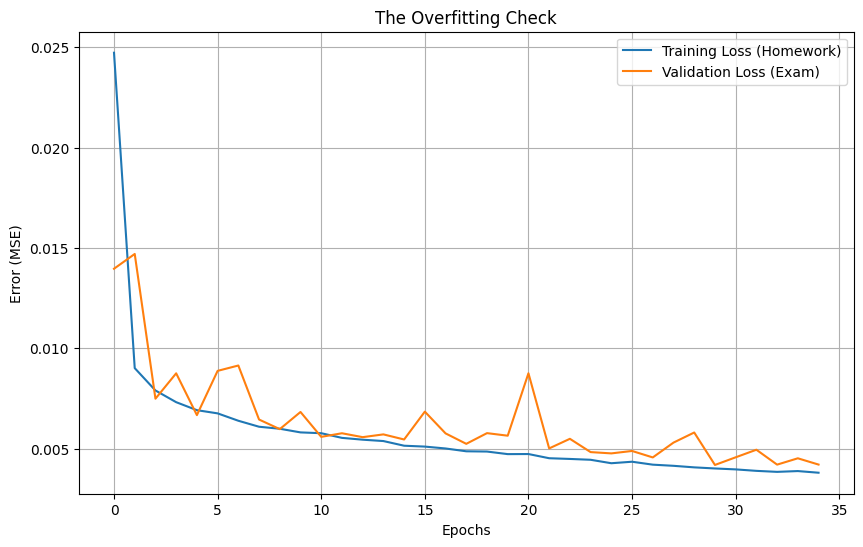

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (Homework)')
plt.plot(history.history['val_loss'], label='Validation Loss (Exam)')
plt.title('The Overfitting Check')
plt.xlabel('Epochs')
plt.ylabel('Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def clean_audio_hybrid(audio_path, model, output_path):
    print(f"Processing: {audio_path}")

    try:
        audio, sr = librosa.load(audio_path, sr=16000, mono=True)
    except FileNotFoundError:
        print(f"Error: Could not find file '{audio_path}'")
        return

    chunk_len = 128 * 125
    padding = chunk_len - (len(audio) % chunk_len)
    padded_audio = np.pad(audio, (0, padding))

    full_spec = librosa.stft(padded_audio, n_fft=255, hop_length=125)
    full_mag, full_phase = librosa.magphase(full_spec)

    num_chunks = full_mag.shape[1] // 128
    predicted_mags = []

    for i in range(num_chunks):
        seg_mag = full_mag[:, i*128 : (i+1)*128]

        log_mag = np.log1p(seg_mag)
        input_chunk = log_mag.T[np.newaxis, ..., np.newaxis]

        pred = model.predict(input_chunk, verbose=0)

        pred_linear = np.expm1(pred.squeeze().T)
        predicted_mags.append(pred_linear)

    predicted_full_mag = np.hstack(predicted_mags)

    noisy_mag_crop = full_mag[:, :predicted_full_mag.shape[1]]
    noisy_spec_crop = full_spec[:, :predicted_full_mag.shape[1]]

    mask = predicted_full_mag / (noisy_mag_crop + 1e-10)
    mask = np.clip(mask, 0.05, 1.0)

    clean_spec_complex = noisy_spec_crop * mask
    y_reconstructed = librosa.istft(clean_spec_complex, hop_length=125)

    sf.write(output_path, y_reconstructed, 16000)
    print(f"Saved clean audio to: {output_path}")

In [ ]:
my_filename = "my_test.wav"

if os.path.exists(my_filename) and 'model' in globals():
    output_filename = "cleaned_hybrid_" + my_filename

    clean_audio_hybrid(my_filename, model, output_filename)

    print("\nOriginal:")
    ipd.display(ipd.Audio(my_filename))
    print("\nHybrid Cleaned (Best Quality):")
    ipd.display(ipd.Audio(output_filename))

Processing: my_test.wav
Saved clean audio to: cleaned_hybrid_my_test.wav

Original:



Hybrid Cleaned (Best Quality):


In [ ]:
def calculate_snr(clean, noisy):
    # Ensure equal lengths
    min_len = min(len(clean), len(noisy))
    clean = clean[:min_len]
    noisy = noisy[:min_len]

    # Signal Power
    s_power = np.sum(clean ** 2)

    # Noise Power (The difference between the two signals)
    n_power = np.sum((clean - noisy) ** 2)

    if n_power == 0:
        return 100.0 # Perfect match (avoid divide by zero)

    return 10 * np.log10(s_power / n_power)

def calculate_mse(clean, noisy):
    min_len = min(len(clean), len(noisy))
    return np.mean((clean[:min_len] - noisy[:min_len]) ** 2)

In [ ]:
def evaluate_mrdnn_performance(model, num_tests=5):
    results = []
    print(f"Starting Evaluation on {num_tests} random samples...\n")

    clean_dir = 'MS-SNSD/clean_test'
    noise_dir = 'MS-SNSD/noise_test'

    clean_files = [f for f in os.listdir(clean_dir) if f.endswith('.wav')]
    noise_files = [f for f in os.listdir(noise_dir) if f.endswith('.wav')]

    if not clean_files or not noise_files:
        print("Error: Test folders are empty or not found.")
        return

    for i in range(num_tests):
        # A. Create Synthetic Noisy File (Ground Truth Setup)
        c_file = np.random.choice(clean_files)
        n_file = np.random.choice(noise_files)

        # Load
        clean_audio, sr = librosa.load(os.path.join(clean_dir, c_file), sr=16000)
        noise_audio, _ = librosa.load(os.path.join(noise_dir, n_file), sr=16000)

        # Crop to shortest
        min_len = min(len(clean_audio), len(noise_audio))
        # Keep it short for testing (4 seconds)
        max_len = 16000 * 4
        if min_len > max_len: min_len = max_len

        clean_audio = clean_audio[:min_len]
        noise_audio = noise_audio[:min_len]

        # Mix (Add noise at 50% volume)
        mixed_audio = clean_audio + 0.5 * noise_audio

        # Save temp file for the denoiser to read
        temp_noisy_path = "temp_noisy_test.wav"
        temp_clean_path = "temp_clean_test.wav"
        sf.write(temp_noisy_path, mixed_audio, 16000)

        # B. Measure Latency & Denoise
        start_time = time.time()

        # Run your Hybrid Denoise Function
        clean_audio_hybrid(temp_noisy_path, model, temp_clean_path)

        end_time = time.time()

        # C. Calculate Metrics
        denoised_audio, _ = librosa.load(temp_clean_path, sr=16000)

        # 1. Latency
        latency_ms = (end_time - start_time) * 1000
        time_per_sec = latency_ms / (min_len / 16000) # ms processing per second of audio

        # 2. SNR
        input_snr = calculate_snr(clean_audio, mixed_audio)
        output_snr = calculate_snr(clean_audio, denoised_audio)
        snr_improvement = output_snr - input_snr

        # 3. MSE
        mse_score = calculate_mse(clean_audio, denoised_audio)

        # Log Logic
        print(f"Test {i+1}: Noise='{n_file}'")
        print(f"   ⏱️ Latency: {latency_ms:.0f}ms ({time_per_sec:.0f}ms per sec of audio)")
        print(f"   📉 Input SNR: {input_snr:.2f} dB")
        print(f"   📈 Output SNR: {output_snr:.2f} dB (Improved by {snr_improvement:.2f} dB)")
        print(f"   ba MSE Error: {mse_score:.5f}")
        print("-" * 30)

        results.append({
            "Clean File": c_file,
            "Noise Type": n_file,
            "Input SNR (dB)": input_snr,
            "Output SNR (dB)": output_snr,
            "SNR Improvement": snr_improvement,
            "MSE": mse_score,
            "Latency (ms)": latency_ms
        })

    # D. Summary Table
    df = pd.DataFrame(results)
    print("\n🏆 FINAL RESULTS SUMMARY:")
    print(df.describe().loc[['mean', 'min', 'max']])
    return df

In [ ]:
if 'denoiser_model' not in globals():
    denoiser_model = tf.keras.models.load_model('best_mrdnn.keras')

metrics_df = evaluate_mrdnn_performance(denoiser_model, num_tests=5)

Starting Evaluation on 5 random samples...

Processing: temp_noisy_test.wav
Saved clean audio to: temp_clean_test.wav
Test 1: Noise='Munching_5.wav'
   ⏱️ Latency: 1747ms (437ms per sec of audio)
   📉 Input SNR: 9.78 dB
   📈 Output SNR: 7.40 dB (Improved by -2.38 dB)
   ba MSE Error: 0.00024
------------------------------
Processing: temp_noisy_test.wav
Saved clean audio to: temp_clean_test.wav
Test 2: Noise='Babble_5.wav'
   ⏱️ Latency: 468ms (117ms per sec of audio)
   📉 Input SNR: 0.93 dB
   📈 Output SNR: 5.13 dB (Improved by 4.20 dB)
   ba MSE Error: 0.00049
------------------------------
Processing: temp_noisy_test.wav
Saved clean audio to: temp_clean_test.wav
Test 3: Noise='AirportAnnouncements_3.wav'
   ⏱️ Latency: 379ms (95ms per sec of audio)
   📉 Input SNR: -4.96 dB
   📈 Output SNR: 2.49 dB (Improved by 7.46 dB)
   ba MSE Error: 0.00100
------------------------------
Processing: temp_noisy_test.wav
Saved clean audio to: temp_clean_test.wav
Test 4: Noise='Neighbor_1.wav'
   ⏱️

<h2><b> CNN Classification

In [ ]:
DATASET_PATH = 'MS-SNSD/noise_train'
SAMPLE_RATE = 16000
DURATION = 1.0
N_MELS = 128

In [ ]:
TARGET_CLASSES = [
    'AirConditioner', 'CopyMachine', 'Munching', 'NeighborSpeaking',
    'SqueakyChair', 'Typing', 'VacuumCleaner', 'WasherDryer'
]

In [ ]:
def extract_mel_spec(audio):
    # Convert audio chunk to image
    melspec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    # Normalize 0-1
    melspec_db = (melspec_db - melspec_db.min()) / (melspec_db.max() - melspec_db.min() + 1e-10)
    return melspec_db[..., np.newaxis]

def prepare_augmented_data():
    X = []
    Y = []

    print("Generating Augmented Dataset (This will take a few minutes)...")

    files = os.listdir(DATASET_PATH)

    for file in files:
        if not file.endswith('.wav'): continue

        label = file.split('_')[0]
        if label not in TARGET_CLASSES: continue

        file_path = os.path.join(DATASET_PATH, file)

        try:
            # 1. LOAD ORIGINAL
            audio, _ = librosa.load(file_path, sr=SAMPLE_RATE)

            # Helper to process chunks
            def process_chunks(audio_data):
                samples_per_chunk = int(SAMPLE_RATE * DURATION)
                n_chunks = len(audio_data) // samples_per_chunk
                for i in range(n_chunks):
                    chunk = audio_data[i*samples_per_chunk : (i+1)*samples_per_chunk]
                    X.append(extract_mel_spec(chunk))
                    Y.append(label)

            # --- A. ORIGINAL (The baseline) ---
            process_chunks(audio)

            # --- B. AUGMENT: PITCH SHIFT (Simulate different fan speeds) ---
            # Shift pitch up by 2 steps
            audio_pitch = librosa.effects.pitch_shift(audio, sr=SAMPLE_RATE, n_steps=2)
            process_chunks(audio_pitch)

            # --- C. AUGMENT: TIME STRETCH (Simulate faster typing) ---
            # Speed up by 20%
            audio_fast = librosa.effects.time_stretch(audio, rate=1.2)
            process_chunks(audio_fast)

            # --- D. AUGMENT: NOISE INJECTION (Add static) ---
            noise = np.random.randn(len(audio))
            audio_noisy = audio + 0.005 * noise
            process_chunks(audio_noisy)

        except Exception as e:
            print(f"Error on {file}: {e}")

    return np.array(X), np.array(Y)

In [ ]:
X_aug, Y_aug_raw = prepare_augmented_data()

Generating Augmented Dataset (This will take a few minutes)...


In [ ]:
le = LabelEncoder()
Y_aug = to_categorical(le.fit_transform(Y_aug_raw))

In [ ]:
X_train_c, X_test_c, Y_train_c, Y_test_c = train_test_split(X_aug, Y_aug, test_size=0.2, random_state=42)

print(f"✅ Data Ready!")
print(f"Total Augmented Samples: {len(X_aug)}")
print(f"Training on: {X_train_c.shape[0]} samples")

✅ Data Ready!
Total Augmented Samples: 19508
Training on: 15606 samples


In [ ]:
def build_classifier(input_shape, num_classes):
    model = Sequential([
        # Layer 1
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # Layer 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # Layer 3
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # Flatten
        Flatten(),

        # Dense
        Dense(128, activation='relu'),
        Dropout(0.4), # Increased dropout to prevent overfitting

        # Output
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
early_stopper_cls = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpointer_cls = ModelCheckpoint(
    filepath='best_classifier.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

input_shape_cls = X_train_c.shape[1:]
num_classes = Y_cls.shape[1]

classifier = build_classifier(input_shape_cls, num_classes)

print("Starting Training...")
history_cls = classifier.fit(
    X_train_c, Y_train_c,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_c, Y_test_c),
    callbacks=[early_stopper_cls, checkpointer_cls]
)

# Save the final (best) version clearly
classifier.save('final_noise_classifier.keras')
print("✅ Classification Training Complete.")

Starting Training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6822 - loss: 1.0449
Epoch 1: val_accuracy improved from -inf to 0.34982, saving model to best_classifier.keras
488/488 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6824 - loss: 1.0441 - val_accuracy: 0.3498 - val_loss: 2.6691
Epoch 2/100
482/488 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9170 - loss: 0.2677
Epoch 2: val_accuracy improved from 0.34982 to 0.88288, saving model to best_classifier.keras
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9171 - loss: 0.2674 - val_accuracy: 0.8829 - val_loss: 0.4329
Epoch 3/100
484/488 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9438 - loss: 0.1689
Epoch 3: val_accuracy improved from 0.88288 to 0.94567, saving model to best_classifier.keras
488/488 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9438 - loss: 0.1689 - val_accuracy: 0.9457 - val_loss: 0.1578
Epoch 4/100
485/488 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9604 - loss: 0.1184
Epoch 4: val_accura

Predicting...
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


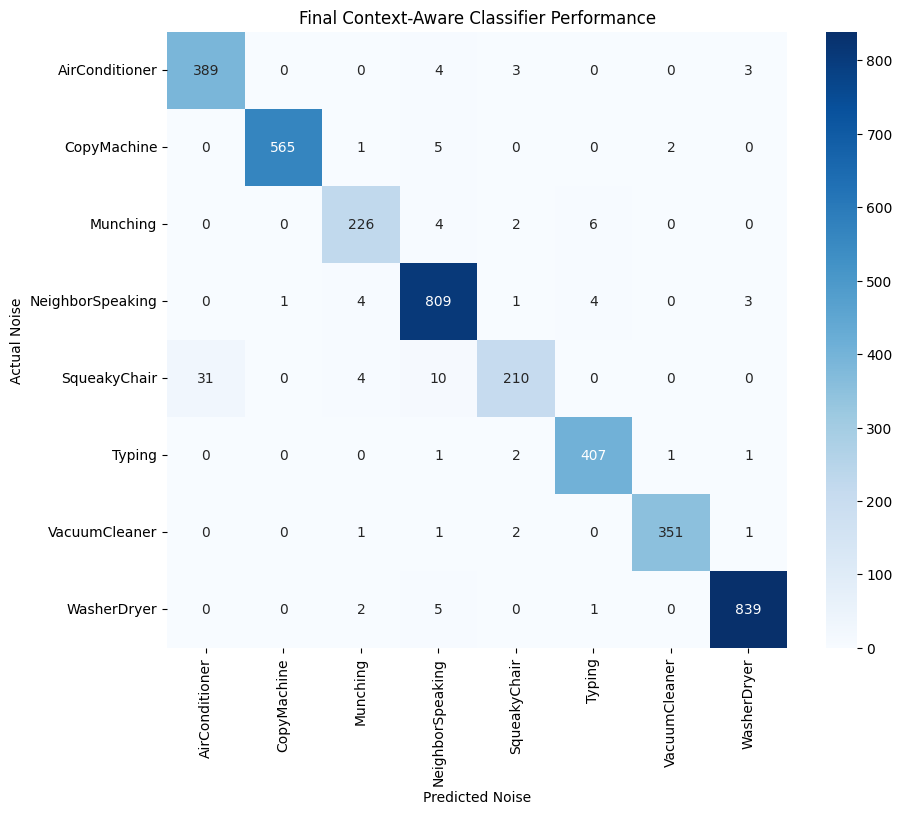

                  precision    recall  f1-score   support

  AirConditioner       0.93      0.97      0.95       399
     CopyMachine       1.00      0.99      0.99       573
        Munching       0.95      0.95      0.95       238
NeighborSpeaking       0.96      0.98      0.97       822
    SqueakyChair       0.95      0.82      0.88       255
          Typing       0.97      0.99      0.98       412
   VacuumCleaner       0.99      0.99      0.99       356
     WasherDryer       0.99      0.99      0.99       847

        accuracy                           0.97      3902
       macro avg       0.97      0.96      0.96      3902
    weighted avg       0.97      0.97      0.97      3902



In [ ]:
print("Predicting...")
y_pred = classifier.predict(X_test_c)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test_c, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Final Context-Aware Classifier Performance')
plt.ylabel('Actual Noise')
plt.xlabel('Predicted Noise')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=le.classes_))